# Clasificador COVID-19

El problema a resolver es la clasificación de imágenes de muestras vísricas para detectar el virus *COVID-19*.

Esta prueba deberá ser capaz de reconocer si el paciente está infectado por algun virus de la familia *Coronaviridae*, que con mucha probabilidad, será el *COVID-19*.

In [1]:
import tensorflow as tf
import numpy as np
import os # Funciones del sistema operativo
from PIL import Image # Para obtener el valor de los pixeles de las imágenes
import matplotlib.pyplot as plt
import random as rng
from tensorflow.keras import layers, models

## Datos

Se usará el 80% de los datos para entrenamiento, y el 20% restante para evaluar el modelo.

Los datos serán imágenes en blanco y negro de distintos tamaños, y estarán etiquetadas como **muestra vacía**, **otro virus** o ***COVID-19***.

In [2]:
IMG_SIZE = 500
BIG_IMG_SIZE = 750

In [3]:
className = ["blank", "other", "coronaviridae"]

Transformar las imágenes a blanco y negro puro, porque parece haber errores en las imágenes, y se detectan como RGB en lugar de escala de grises. También se va a definir un tamaño de **500x500**px.

Se dividen los datos en el set de entrenamiento y evaluación. 

In [4]:
trainingSet = []
evaluationSet = []

bigSizeTraining = []

for folder in os.listdir('./images'):
    for i, img in enumerate(os.listdir('./images/' + folder)):
        imgClass = folder        
        path = os.path.join('./images/' + folder, img)
        imgData = Image.open(path)
        imgData = imgData.convert("L")
        
        bigImg = imgData.resize((BIG_IMG_SIZE, BIG_IMG_SIZE), Image.ANTIALIAS)
        bigImg = np.array(bigImg)
        
        imgData = imgData.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        imgData = np.array(imgData)
        if i % 10 < 8:
            bigSizeTraining.append((bigImg, imgClass))
            trainingSet.append((imgData, imgClass))
        else:
            evaluationSet.append((imgData, imgClass))       

In [5]:
print("Tamaño del set de entrenamiento: ", len(trainingSet))
print("Tamaño del set de evaluación: ", len(evaluationSet))

Tamaño del set de entrenamiento:  102
Tamaño del set de evaluación:  24


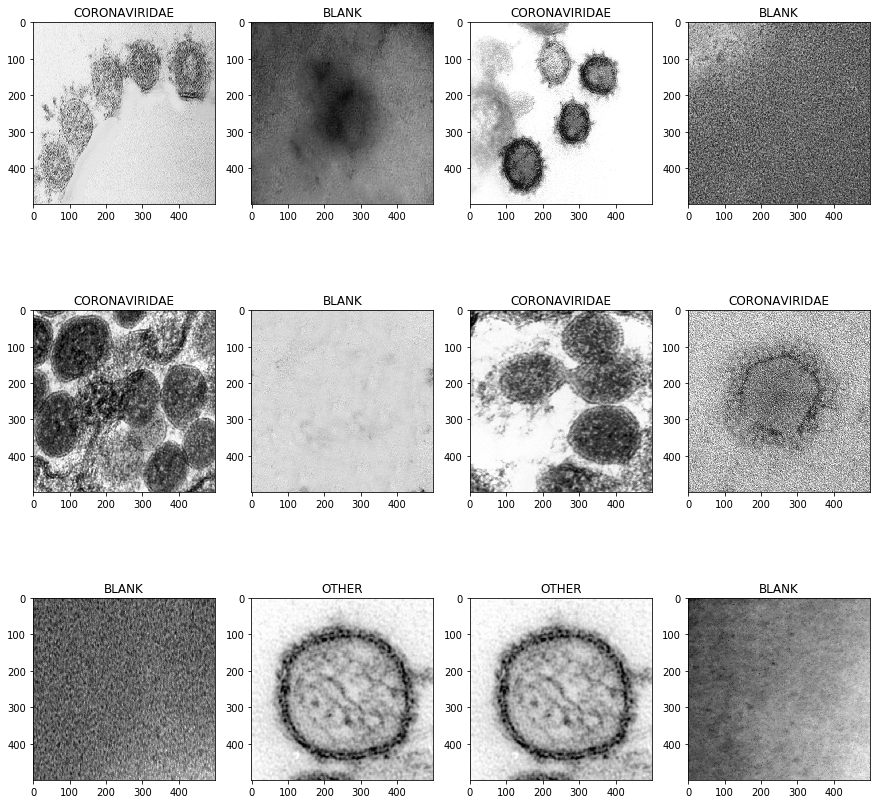

In [6]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    data = trainingSet[np.random.randint(len(trainingSet))]
    img = data[0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = 'gist_gray')
    plt.title(data[1].upper())
plt.show()

Dado que el número de datos que se tienen es muy reducido, se va a optar por usar técnicas para aumentar el número de datos. Esto se hace para evitar el *overfitting*, dado que con un número pequeño de datos, es más fácil que se produzca.

El aumento de datos se realizará en todas las imágenes de entrenamiento, para aumentar el máximo posible el número de datos. En un principio no se va a realizar un aumento de datos al set evaluación.

Las técnicas de aumento de datos que se van a utilzar son: **rotación**, **volteo**, **traslación** y **zoom**. También se hacee una combinación entre zoom, y rotación y volteo.

Otras técnicas que serían también útiles son: alejar la imagen, rotaciones no solo de 90º, mezclar varias técnicas de distinta forma, añadir ruido, invertir los colores de la imagen, etc.

Se van a realizar 3 volteos, 3 rotaciones, 4 traslaciones, 1 zoom y 3 zoom con rotación y 3 zoom con volteo. De forma que por cada imagen se crean 17 nuevas.

In [7]:
newTrainingSet = []

for data in trainingSet:
    
    #Imágenes con volteo
    
    newImgFlipUD = np.flipud(data[0]) #Volteo de arriba a abajo
    newImgFlipLR = np.fliplr(data[0]) #Volteo de izquierda a derecha
    newImgFlipUDLR = np.flip(data[0], (0, 1)) #Volteo izquierda-derecha y arriba-abajo 
    
    #Imágenes con rotación
    
    newImgRot1 = np.rot90(data[0]) #Una rotación de 90º
    newImgRot2 = np.rot90(data[0], 2) #Dos rotaciones de 90º
    newImgRot3 = np.rot90(data[0], 3) #Tres rotaciones de 90º
    
    #Imágenes con traslación
    
    newImgDown = np.zeros(data[0].shape)
    newImgUp = np.zeros(data[0].shape)
    newImgLeft = np.zeros(data[0].shape)
    newImgRight = np.zeros(data[0].shape)
    

    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            newImgDown[i][j] = data[0][(i-200)%IMG_SIZE][j] #Traslación hacia abajo
            newImgUp[i][j] = data[0][(i+200)%IMG_SIZE][j] #Traslación hacia arriba
            newImgLeft[i][j] = data[0][i][(j+200)%IMG_SIZE] #Traslación hacia izquierda
            newImgRight[i][j] = data[0][i][(j-200)%IMG_SIZE] #Traslación hacia derecha

        
    newTrainingSet.append((newImgFlipUD, data[1]))
    newTrainingSet.append((newImgFlipLR, data[1]))
    newTrainingSet.append((newImgFlipUDLR, data[1]))
    
    newTrainingSet.append((newImgRot1, data[1]))
    newTrainingSet.append((newImgRot2, data[1]))
    newTrainingSet.append((newImgRot3, data[1]))    
    
    newTrainingSet.append((newImgDown, data[1]))
    newTrainingSet.append((newImgUp, data[1]))
    newTrainingSet.append((newImgLeft, data[1]))
    newTrainingSet.append((newImgRight, data[1]))  
    
    
trainingSet += newTrainingSet

In [8]:
newTrainingSet = []

for data in bigSizeTraining:
    
    newImgZoom = data[0].copy()
    
    newImgZoom = newImgZoom[250:]
    newImgZoom = np.rot90(newImgZoom)
    newImgZoom = newImgZoom[250:]
    
    newTrainingSet.append((newImgZoom, data[1]))
    newTrainingSet.append((np.rot90(newImgZoom), data[1]))
    newTrainingSet.append((np.rot90(newImgZoom, 2), data[1]))
    newTrainingSet.append((np.rot90(newImgZoom, 3), data[1]))
    
    newTrainingSet.append((np.flipud(newImgZoom), data[1]))
    newTrainingSet.append((np.fliplr(newImgZoom), data[1]))
    newTrainingSet.append((np.flip(newImgZoom, (0, 1)), data[1]))
    
    newImgZoom2 = data[0].copy()
    
    newImgZoom2 = newImgZoom2[:500]
    newImgZoom2 = np.rot90(newImgZoom2)
    newImgZoom2 = newImgZoom2[:500]
    
    newTrainingSet.append((newImgZoom2, data[1]))
    newTrainingSet.append((np.rot90(newImgZoom2), data[1]))
    newTrainingSet.append((np.rot90(newImgZoom2, 2), data[1]))
    newTrainingSet.append((np.rot90(newImgZoom2, 3), data[1]))
    
    newTrainingSet.append((np.flipud(newImgZoom2), data[1]))
    newTrainingSet.append((np.fliplr(newImgZoom2), data[1]))
    newTrainingSet.append((np.flip(newImgZoom2, (0, 1)), data[1]))
    
    
trainingSet += newTrainingSet

Dado que el número de imágenes de evaluación es también muy reducido, se realiza un aumento de datos, usando las técnicas de volteo y rotación.

In [9]:
newEvaluationSet = []

for data in evaluationSet:

    newEvaluationSet.append((np.flipud(data[0]), data[1])) #Volteo de arriba a abajo
    newEvaluationSet.append((np.fliplr(data[0]), data[1])) #Volteo de izquierda a derecha
    newEvaluationSet.append((np.flip(data[0], (0, 1)), data[1])) #Volteo izquierda-derecha y arriba-abajo 

    newEvaluationSet.append((np.rot90(data[0]), data[1])) #Una rotación de 90º
    newEvaluationSet.append((np.rot90(data[0], 2), data[1])) #Dos rotaciones de 90º
    newEvaluationSet.append((np.rot90(data[0], 3), data[1])) #Tres rotaciones de 90º

evaluationSet += newEvaluationSet

In [10]:
rng.shuffle(trainingSet)

In [11]:
print("Tamaño del set de entrenamiento ampliado: ", len(trainingSet))
print("Tamaño del set de evaluación ampliado: ", len(evaluationSet))

Tamaño del set de entrenamiento ampliado:  2550
Tamaño del set de evaluación ampliado:  168


## Modelo

Se va a utilizar una **red neuronal convolucional** (CNN) porque es un problema de clasificación de imágenes.

Este modelo recibe como entrada un vector tridimensional de dimensiones **500x500x1** y tiene como salida **3** posibles clases.

La arquitectura usada para ello es: 6 capas convolucionales, una capa densa y una capa de salida.

In [12]:
model = models.Sequential()

### Capas convolucionales

Cada capa convolucional está seguida por una capa de *pooling* y de *batch normalization*.

In [13]:
#Capa de entrada
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(96, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 249, 249, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 32)      4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 32)      0

### Capa densa

Para poder recibir la entrada en la capa densa es necesario que el vector sea unidimensional. Por tanto, usamos una capa de *flatten*.

In [15]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(3))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 249, 249, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 32)      4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 32)      0

### Compilación del modelo

La función de optimización que se usa en el modelo es *adam*, que experimentalmente ofrece mejores resultados que *descenso del gradiente*. La función de coste va a ser *SparseCategoricalCrossentropy*, que calcula la entropia como la probabilidad entre dos distribuciones. Se utiliza generalmente en problemas con más de dos clases, como es el caso.

In [17]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

### Entrenando el modelo

El entrenamiento va a ser muy ligero, con tan solo 20 *epoch*, para que actue como demo y se pueda comprobar si es útil o no.

In [18]:
trainingData = []
trainingLabel = []

testData = []
testLabel = []

for element in trainingSet:
    trainingData.append(np.reshape(element[0], (IMG_SIZE, IMG_SIZE, 1)))
    trainingLabel.append(className.index(element[1]))

for element in evaluationSet:
    testData.append(np.reshape(element[0], (IMG_SIZE, IMG_SIZE, 1)))
    testLabel.append(className.index(element[1]))

trainingData = np.array(trainingData)
trainingLabel = np.array(trainingLabel)

testData = np.array(testData)
testLabel = np.array(testLabel)

In [19]:
history = model.fit(trainingData, trainingLabel, batch_size=25, epochs=20, validation_data=(testData, testLabel))

Train on 2550 samples, validate on 168 samples
Epoch 1/20
2550/2550 [==============================] - 274s 107ms/sample - loss: 0.8826 - accuracy: 0.5761 - val_loss: 2.0590 - val_accuracy: 0.3750
Epoch 2/20
2550/2550 [==============================] - 195s 77ms/sample - loss: 0.5780 - accuracy: 0.6729 - val_loss: 0.9923 - val_accuracy: 0.5417
Epoch 3/20
2550/2550 [==============================] - 192s 75ms/sample - loss: 0.5557 - accuracy: 0.6961 - val_loss: 0.5198 - val_accuracy: 0.7083
Epoch 4/20
2550/2550 [==============================] - 192s 75ms/sample - loss: 0.4923 - accuracy: 0.7298 - val_loss: 0.8605 - val_accuracy: 0.6845
Epoch 5/20
2550/2550 [==============================] - 196s 77ms/sample - loss: 0.4286 - accuracy: 0.7824 - val_loss: 0.7113 - val_accuracy: 0.7679
Epoch 6/20
2550/2550 [==============================] - 193s 76ms/sample - loss: 0.4117 - accuracy: 0.8071 - val_loss: 0.5487 - val_accuracy: 0.6131
Epoch 7/20
2550/2550 [==============================] - 18

168/1 - 2s - loss: 0.3225 - accuracy: 0.7976


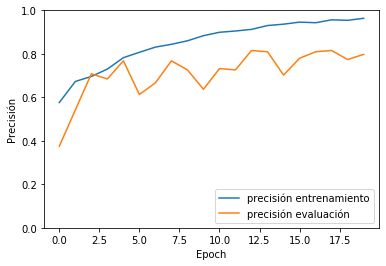

In [20]:
plt.plot(history.history['accuracy'], label='precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label = 'precisión evaluación')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testData,  testLabel, verbose=2)

### Guardar el modelo

In [21]:
model.save('./modelo')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./modelo/assets
